# Notes

# Preamble (must run)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from utils import read_stats, assign_channels, plot_kde, filter_df, add_jitter, purity_thresholds, bin_norm_heatmap, bin_wise_boxplot
import scipy
from itertools import combinations, product
from tqdm import tqdm
import traceback
import scipy.stats
import sklearn
import sklearn.metrics
import os
import pickle
import timeit
import skmisc.loess
plt.rcParams['figure.figsize'] = [10,10]
rng = np.random.default_rng()

# Define samples and channels (must run)

In [2]:
channels={1:'GFP',2:'Polr2a',3:'CD4',4:'Foxp3',5:'Ki67',6:'PD1',7:'CD3',8:'pSTAT5',9:'CD86',10:'dump',11:'dump'}

infected_samples=['r9','r11']
control_samples=['r8','r10']
samples=infected_samples+control_samples

def condition(sample):
    if sample in infected_samples:
        return 'infected'
    elif sample in control_samples:
        return 'control' 
    else:
        raise RuntimeError(f'Unknown condition {sample}')

In [3]:
# os.listdir('..\\250104_flu')

# Import Segmentation Data  (must run)

In [4]:
imported=True

if not imported:
    cells={}
    # for sample in samples:
    #     cells[f'{sample}_paracortex']=assign_channels(read_stats(f'..\\240727_ovakldh\\{sample}_paracortex_Statistics',grouped_images=False,verbose=False),channels)
    # for surface in cell_types.keys(): #import segmented Tconv Treg and migratory cell data
    cell_type_label='Polr2a'
    temp_df=assign_channels(read_stats(f'..\\250104_flu\{cell_type_label}_Statistics',grouped_images=True,verbose=True),channels)
    for name,group in temp_df.groupby('Original Image Name'):
        sample_end=name[name.find('region'):][7:] # part of the image name after 'Region'
        sample=sample_end[:sample_end.find('merged')][:-1] # part of the image name before 'Merged'
        cells[f'r{sample}_paracortex']=group
    with open("250108_cell_data.pickle",'wb') as f:
        pickle.dump(cells,f)
else:
    with open('250108_cell_data.pickle','rb') as f:
        cells=pickle.load(f)

In [5]:
cells.keys()

dict_keys(['r9_paracortex', 'r8_paracortex', 'r10_paracortex', 'r11_paracortex'])

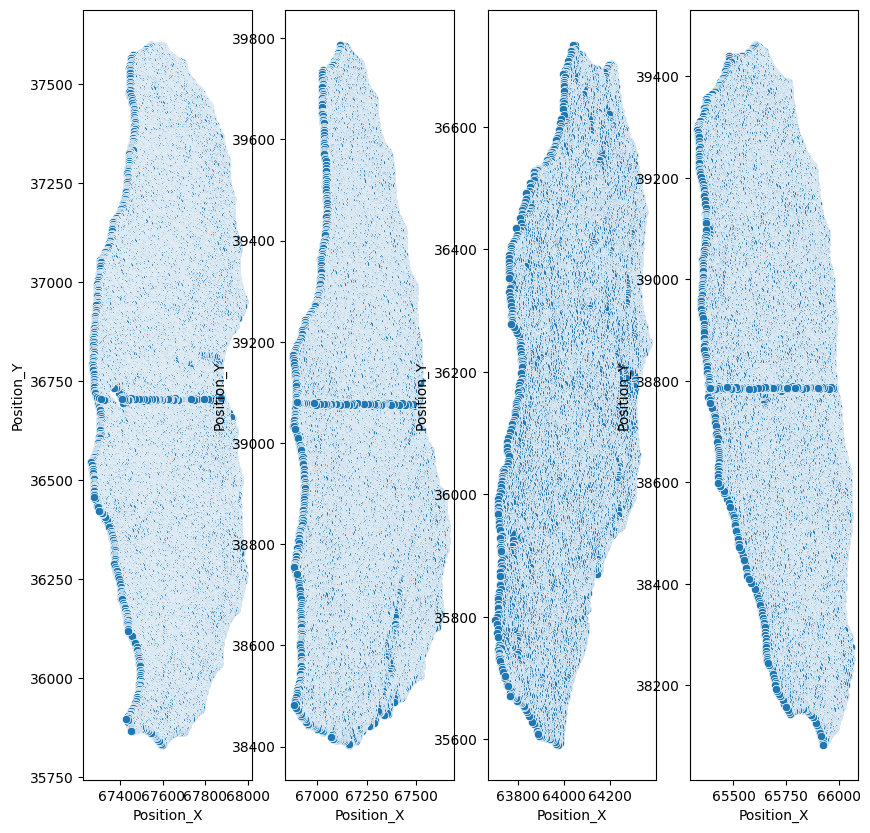

In [6]:
fig,axs=plt.subplots(1,4)
for i,sample in enumerate(samples):
    sns.scatterplot(cells[f'{sample}_paracortex'],x='Position_X',y='Position_Y',ax=axs[i])

# Gating set up

C:\Users\Wong Lab\AppData\Local\Temp\ipykernel_38768\1569526345.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,5000)


Text(0.5, 1.0, 'all paracortex cells')

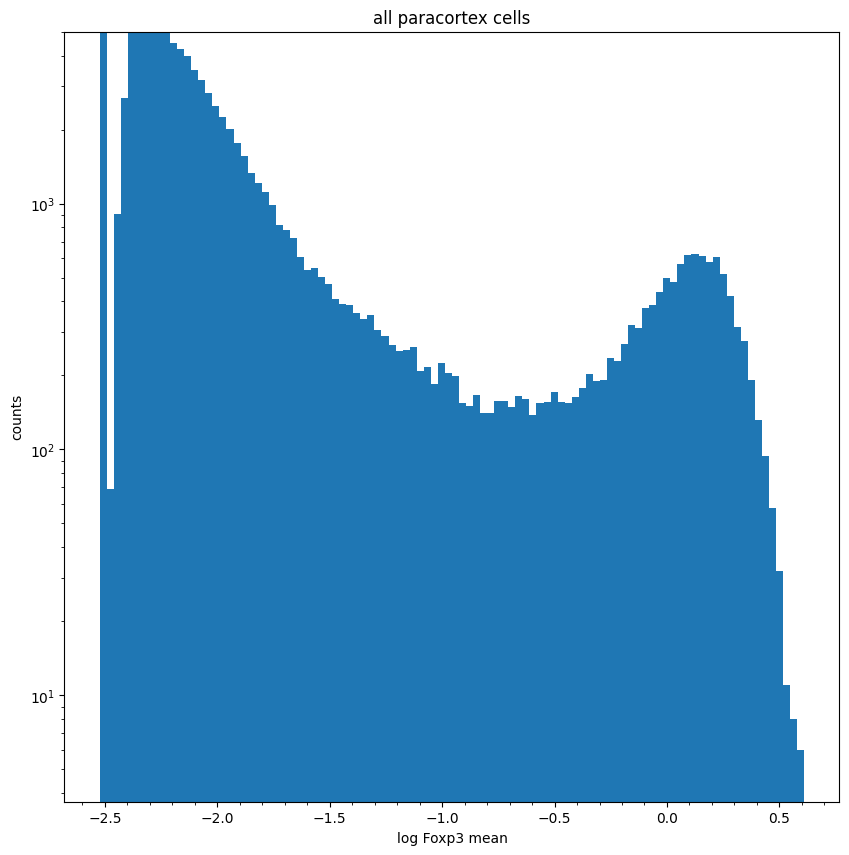

In [23]:
fig,ax=plt.subplots()
ax.hist(pd.concat([np.log10(cells[f'{sample}_paracortex']['Intensity_Mean_Foxp3']+3e-3) for sample in samples]),bins=100)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_yscale('log')
ax.set_ylim(0,5000)
ax.set_xlabel('log Foxp3 mean')
ax.set_ylabel('counts')
ax.set_title('all paracortex cells')

Text(0.5, 1.0, 'all paracortex cells')

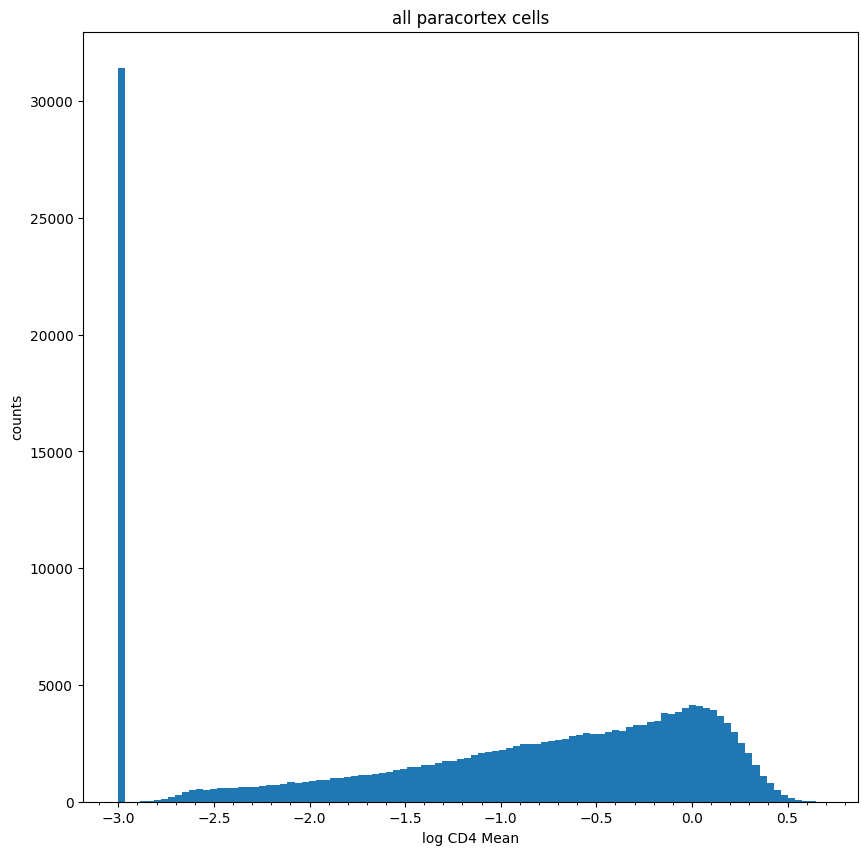

In [25]:
fig,ax=plt.subplots()
ax.hist(pd.concat([np.log10(cells[f'{sample}_paracortex']['Intensity_Mean_CD4']+1e-3) for sample in samples]),bins=100)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# plt.yscale('log')
ax.set_xlabel('log CD4 Mean')
ax.set_ylabel('counts')
ax.set_title('all paracortex cells')

Text(0.5, 1.0, 'all paracortex cells')

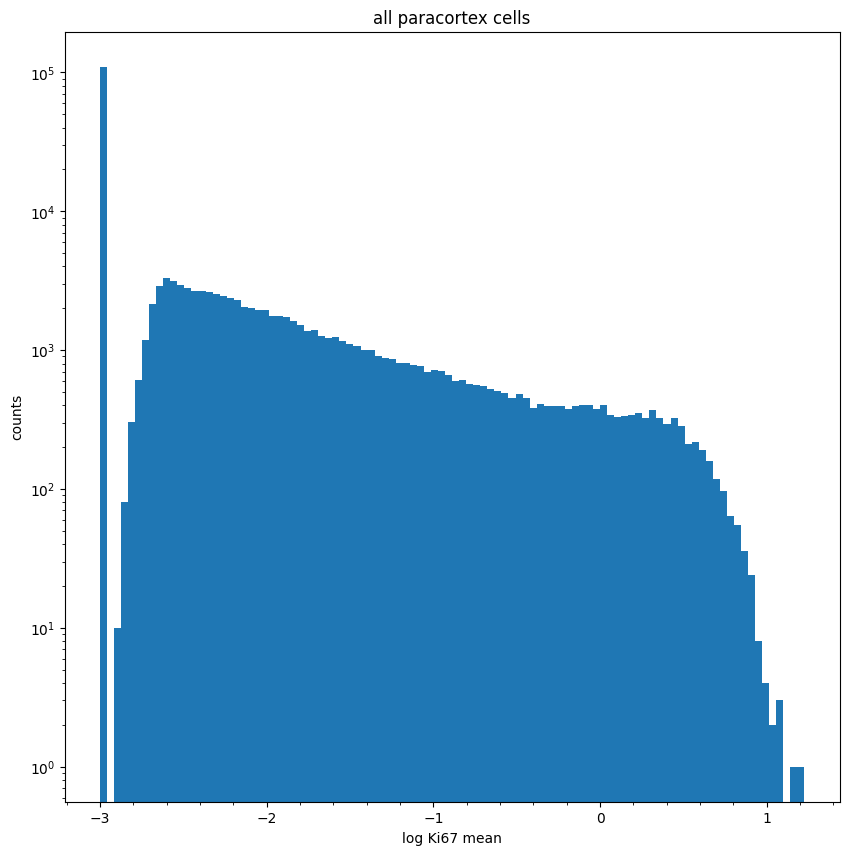

In [26]:
fig,ax=plt.subplots()
ax.hist(pd.concat([np.log10(cells[f'{sample}_paracortex']['Intensity_Mean_Ki67']+1e-3) for sample in samples]),bins=100)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_yscale('log')
ax.set_xlabel('log Ki67 mean')
ax.set_ylabel('counts')
ax.set_title('all paracortex cells')

Text(0.5, 1.0, 'all paracortex cells')

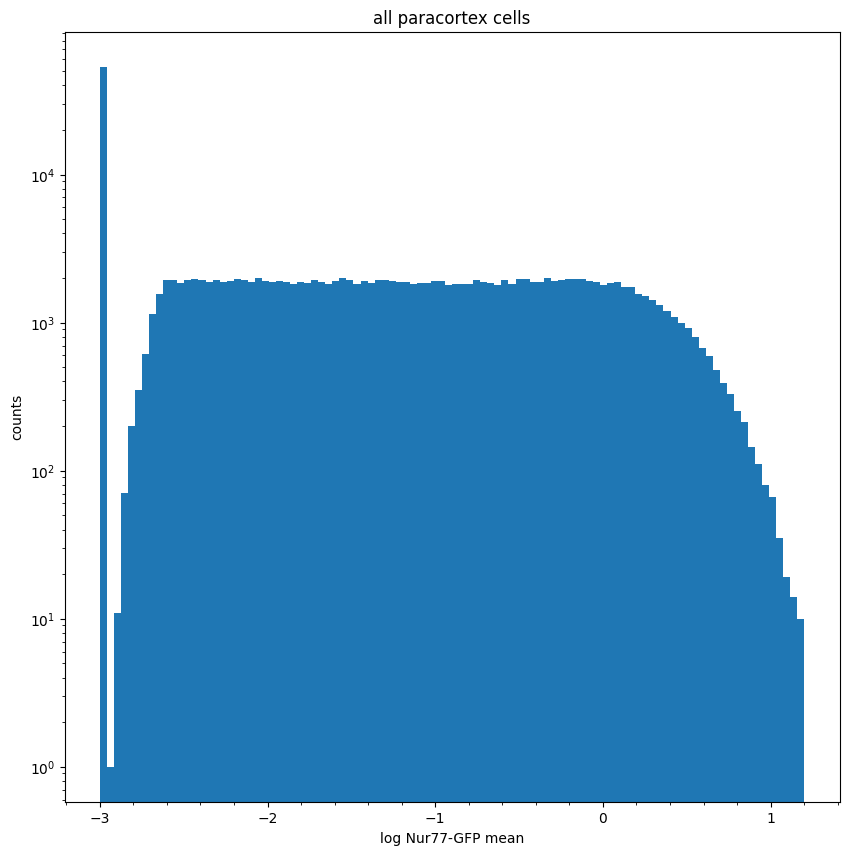

In [32]:
fig,ax=plt.subplots()
ax.hist(pd.concat([np.log10(cells[f'{sample}_paracortex']['Intensity_Mean_GFP']+1e-3) for sample in samples]),bins=100)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_yscale('log')
ax.set_xlabel('log Nur77-GFP mean')
ax.set_ylabel('counts')
ax.set_title('all paracortex cells')

Text(0.5, 1.0, 'all paracortex cells')

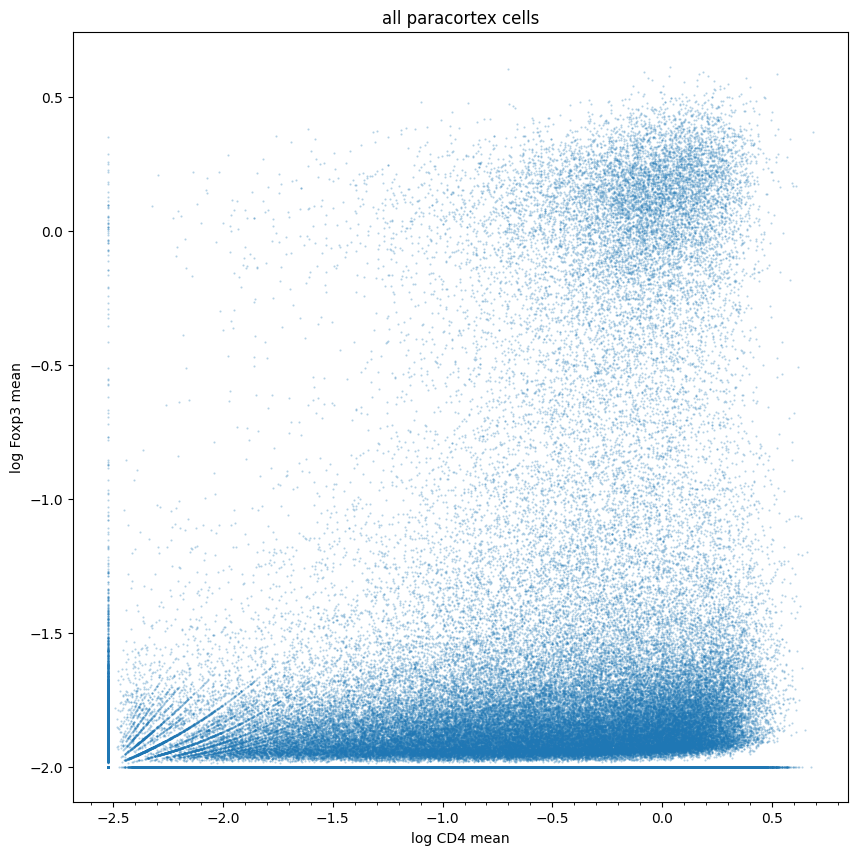

In [29]:
fig,ax=plt.subplots()
ax.scatter(pd.concat([np.log10(cells[f'{sample}_paracortex']['Intensity_Mean_CD4']+3e-3) for sample in samples]),pd.concat([np.log10(cells[f'{sample}_paracortex']['Intensity_Mean_Foxp3']+0.01) for sample in samples]),s=0.3,alpha=0.3)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_xlabel('log CD4 mean')
ax.set_ylabel('log Foxp3 mean')
ax.set_title('all paracortex cells')

# Subset Filtering  (must run)

In [7]:
treg_thresh=10**(-0.5)
th_thresh=10**(-0.3)

In [8]:
Treg_mode='filter'
for sample in samples:
    if Treg_mode=='filter':
        cells[f'{sample}_Treg']=filter_df(cells[f'{sample}_paracortex'],'Intensity_Mean_Foxp3',lambda x: x>=treg_thresh).copy().reset_index(drop=True)
    # elif Treg_mode=='import':
    #     cells[f'{sample}_Treg']=cells[f'{sample}_Foxp3']
    #     cells.pop(f'{sample}_Foxp3')
    cells[f'{sample}_Th']=filter_df(filter_df(cells[f'{sample}_paracortex'],'Intensity_Mean_Foxp3',lambda x: x<treg_thresh),'Intensity_Mean_CD4',lambda x:x>=th_thresh).copy().reset_index(drop=True)
    # cells[f'{sample}_Th_Nur77']=filter_df(filter_df(cells[f'{sample}_Nur77'],'Intensity_Mean_Foxp3',lambda x: x<treg_thresh),'Intensity_Mean_CD4',lambda x:x>=0.96).copy().reset_index(drop=True)



In [9]:
gfp_lo_thresh=0.05
gfp_hi_thresh=2.5

In [10]:
# pstat_thresh=0.15

# Bulk Analysis

Text(0.5, 1.0, 'all paracortex cells')

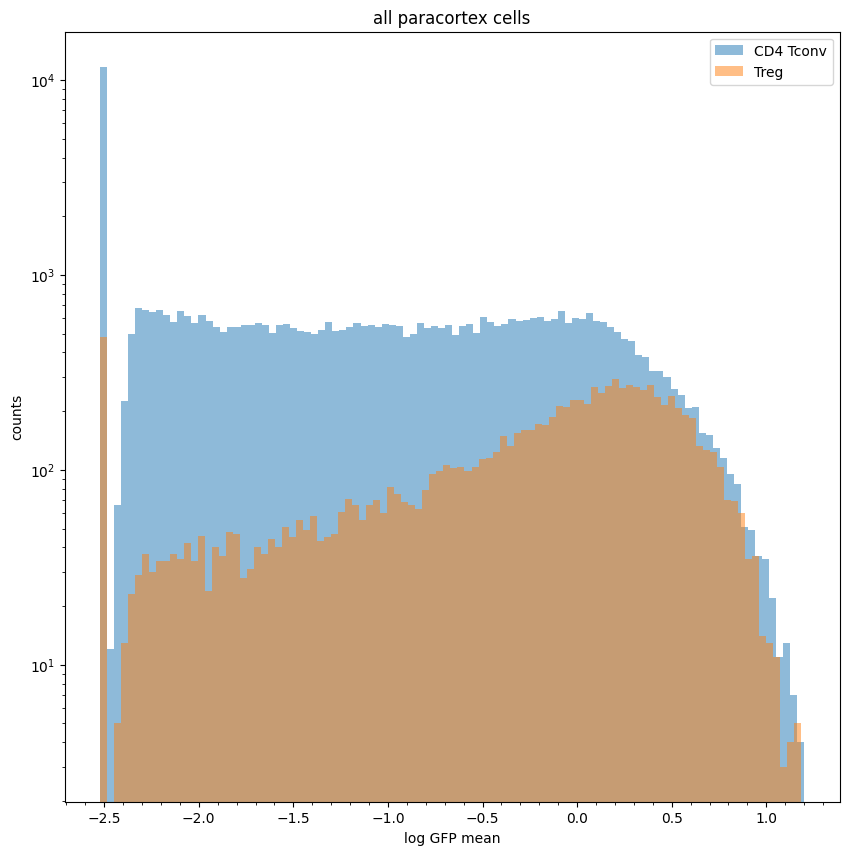

In [11]:
fig,ax=plt.subplots()
ax.hist(pd.concat([np.log10(cells[f'{sample}_Th']['Intensity_Mean_GFP']+3e-3) for sample in samples]),bins=100,alpha=0.5,label='CD4 Tconv')
ax.hist(pd.concat([np.log10(cells[f'{sample}_Treg']['Intensity_Mean_GFP']+3e-3) for sample in samples]),bins=100,alpha=0.5,label='Treg')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('log GFP mean')
ax.set_ylabel('counts')
ax.set_title('all paracortex cells')

In [ ]:
plot_data=[]
for sample in samples:
    plot_data.append(cells[sample+'_Treg']['Intensity_Mean_Ki67'])
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+1e-3) for series in plot_data],showmedians=True)
plt.ylabel('log Ki67 mean')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Tregs')

In [ ]:
plot_data=[filter_df(cells[sample+'_Treg'],'Intensity_Mean_Ki67',lambda x:x>Ki67_low_thresh)['Intensity_Mean_Ki67'] for sample in samples]
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+1e-3) for series in plot_data],showmedians=True)
plt.ylabel('log Ki67 mean')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Ki67+ Tregs')

In [ ]:
plot_data=[filter_df(cells[sample+'_Th'],'Intensity_Mean_Ki67',lambda x:x>Ki67_low_thresh)['Intensity_Mean_Ki67'] for sample in samples]
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+0.2) for series in plot_data],showmedians=True)
plt.ylabel('log Ki67 mean')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[condition(sample) for sample in samples],[len(arr) for arr in plot_data]],
                      rowLabels=['Treatment','Counts'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Ki67+ CD4 Tconvs')

In [ ]:
plot_data=[filter_df(cells[sample+'_Th'],'Intensity_Mean_Ki67',lambda x:x>Ki67_hi_thresh)['Intensity_Mean_Ki67'] for sample in samples]
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+0.2) for series in plot_data],showmedians=True)
plt.ylabel('log Ki67 mean')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[condition(sample) for sample in samples],[len(arr) for arr in plot_data]],
                      rowLabels=['Treatment','Counts'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Ki67 hi CD4 Tconvs')

Text(0, 0.5, 'ecdf')

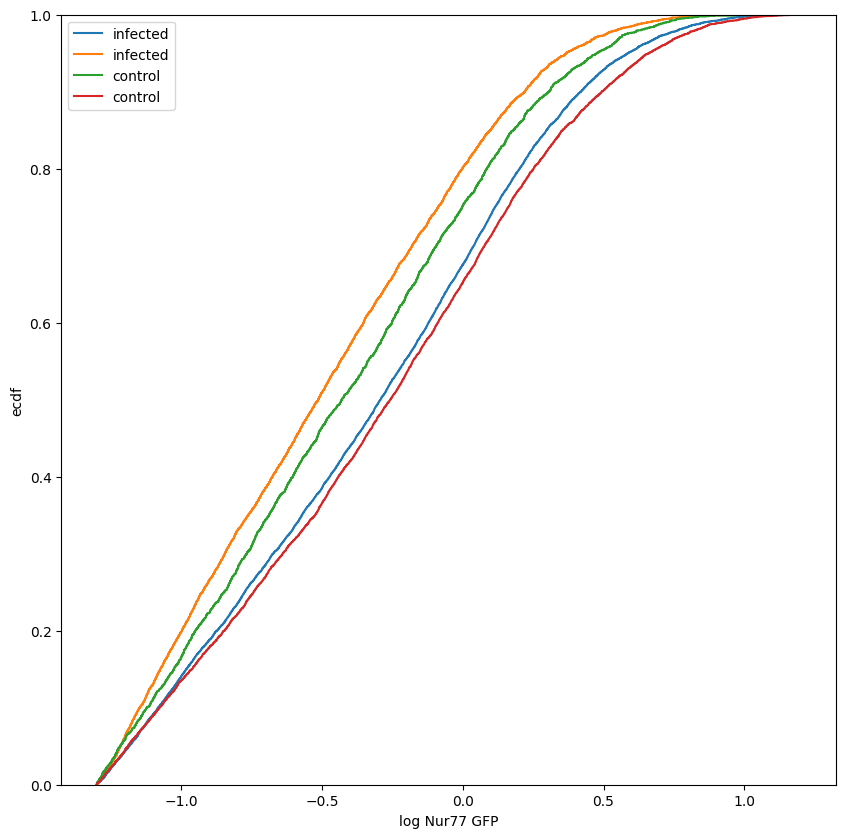

In [50]:
# plot_data=[ for sample in samples]
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])
ax=plt.subplot()
for sample in samples:
    ax.ecdf(np.log10(filter_df(cells[sample+'_Th'],'Intensity_Mean_GFP',lambda x:x>0.05)['Intensity_Mean_GFP']),label=condition(sample))

plt.legend()
plt.xlabel('log Nur77 GFP')
plt.ylabel('ecdf')
# plt.violinplot([ for series in plot_data],showmedians=True)
# plt.ylabel('log GFP mean')
# # plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
# plt.table(cellText=[[condition(sample) for sample in samples],[len(arr) for arr in plot_data]],
#                       rowLabels=['Treatment','Counts'],
#                       loc='bottom',
#                       edges='open')
# plt.xticks([])
# plt.title('CD4 Tconvs')

Text(0.5, 1.0, 'GFP+ CD4 Tconvs')

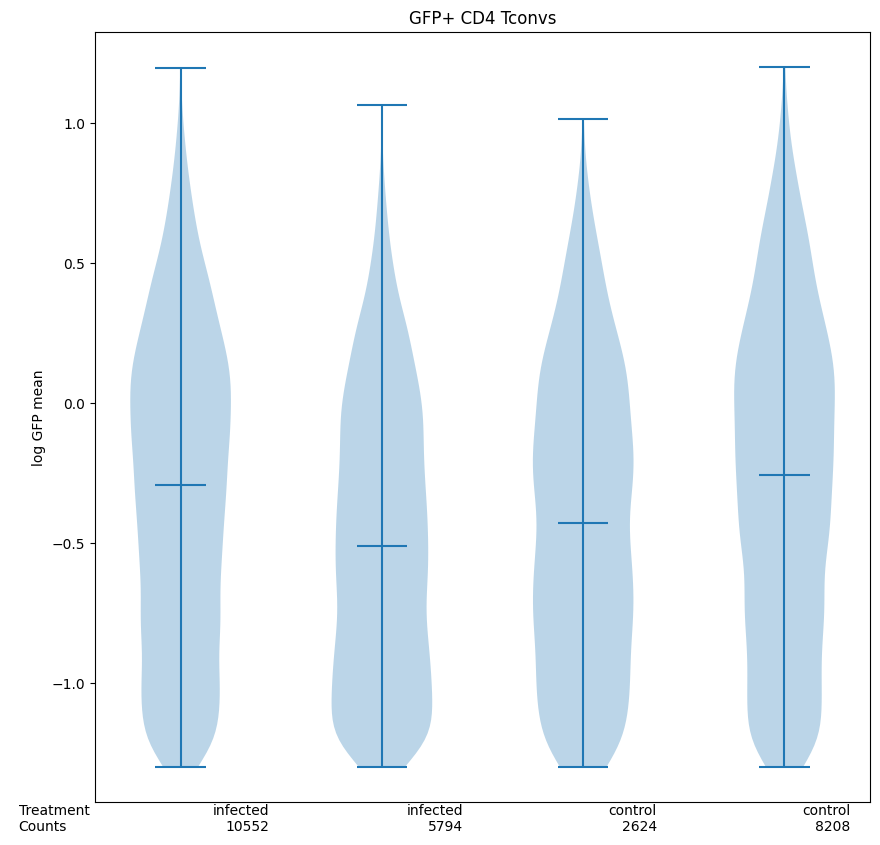

In [12]:
plot_data=[filter_df(cells[sample+'_Th'],'Intensity_Mean_GFP',lambda x:x>gfp_lo_thresh)['Intensity_Mean_GFP'] for sample in samples]
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series) for series in plot_data],showmedians=True)
plt.ylabel('log GFP mean')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[condition(sample) for sample in samples],[len(arr) for arr in plot_data]],
                      rowLabels=['Treatment','Counts'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('GFP+ CD4 Tconvs')

In [ ]:
plot_data=[pd.concat([np.log10(filter_df(cells[f'{sample}_Th'],'Intensity_Mean_Ki67',lambda x:x>=range[0] and x<range[1])['Intensity_Mean_GFP']+1e-3) for sample in samples]) for range in [(0.,Ki67_low_thresh),(Ki67_low_thresh,Ki67_hi_thresh),(Ki67_hi_thresh,255)]]
plt.violinplot(plot_data,showmedians=True)
plt.ylabel('log mean GFP')
plt.title('CD4 Tconv')
plt.table(cellText=[['Ki67 off','Ki67 lo','Ki67 hi']],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open',cellLoc='center')
plt.xticks([])


In [ ]:
x_range=np.arange(0,25000)
for sample in samples:
    plt.scatter(len(cells[f'{sample}_Th']),len(cells[f'{sample}_Treg']),label=condition(sample),c=)
plt.plot(x_range,x_range*0.1,label='10% Tregs')
plt.plot(x_range,x_range*0.15,label='15% Tregs')
plt.legend(loc='upper left')
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Number of CD4 Tconv')
plt.ylabel('Number of Treg')

In [ ]:
plot_data=[cells[sample+'_Th']['Intensity_Mean_cMyc'] for sample in samples]

plt.violinplot([np.log10(series+1e-3) for series in plot_data],showmedians=True)
plt.ylabel('log cMyc mean')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[condition(sample) for sample in samples],[len(arr) for arr in plot_data]],
                      rowLabels=['Treatment','Counts'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('CD4 Tconvs')

In [ ]:
plot_data=[filter_df(cells[sample+'_Th'],'Intensity_Mean_pSTAT5',lambda x:x>pstat_thresh)['Intensity_Mean_pSTAT5'] for sample in samples]
# plot_data=[cells[sample+'_Th']['Intensity_Mean_pSTAT5'] for sample in samples]

plt.violinplot([np.log10(series+1e-3) for series in plot_data],showmedians=True)
plt.ylabel('log pSTAT5 mean')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[condition(sample) for sample in samples],[len(arr) for arr in plot_data]],
                      rowLabels=['Treatment','Counts'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('pSTAT5+ CD4 Tconvs')

In [ ]:
plt.scatter([0 if condition(sample)=='KLH' else 1 for sample in samples],[np.sum(np.int8(cells[sample+'_Th']['Intensity_Mean_pSTAT5']>pstat_thresh))/len(cells[sample+'_Th']) for sample in samples])
plt.xticks([0,1],['KLH','OVA'])
plt.ylabel('Fraction of pSTAT5+ cells among CD4 Tconv')

In [ ]:
plt.scatter([0 if condition(sample)=='KLH' else 1 for sample in samples],[np.sum(np.int8(cells[sample+'_Polr2a']['Intensity_Mean_pSTAT5']>pstat_thresh))/len(cells[sample+'_Polr2a']) for sample in samples])
plt.xticks([0,1],['KLH','OVA'])
plt.ylabel('Fraction of pSTAT5+ cells among all paracortical cells')

In [ ]:
plt.scatter([0 if condition(sample)=='KLH' else 1 for sample in samples],[np.sum(np.int8(cells[sample+'_Treg']['Intensity_Mean_pSTAT5']>pstat_thresh))/len(cells[sample+'_Treg']) for sample in samples],alpha=0.5)
plt.xticks([0,1],['KLH','OVA'])
plt.ylabel('Fraction of pSTAT5+ cells among all Tregs')

In [48]:
# fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
# for i,sample in enumerate(samples):
#     ax=axs[i//3,i%3]
#     ax.scatter(np.log10(cells[f'{sample}_Th']['Intensity_Mean_GFP']+1e-3),np.log10(cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']+1e-3),s=0.5,alpha=0.2)
# fig.supxlabel('log GFP MFI')
# fig.supylabel('log pSTAT5 MFI')
# fig.suptitle('CD4 Tconv')

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i,sample in enumerate(samples):
    ax=axs[i//3,i%3]
    bin_wise_boxplot(np.log10(cells[f'{sample}_Th']['Intensity_Mean_GFP']+1e-3),np.log10(cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']+1e-3),ax=ax)
fig.supxlabel('log GFP MFI')
fig.supylabel('log pSTAT5 MFI')
fig.suptitle('CD4 Tconv')

# Compute Spatial Statistics  (must run)

In [13]:
d_max=40
# nur77_thresh=50
# nur77_thresh_mean=2.30
# n_bins_GFP=10
# _,log_GFP_bins=np.histogram(np.concatenate([np.log10(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']+0.5) for sample in samples]),bins=n_bins_GFP)

In [14]:
cell_pairs={}
for sample in samples:
    if condition(sample)=='uninjected':
        pair_types=[('Th','Treg')]
    else:
        pair_types=[('Th','Treg'),('Th','Th')]
    for pair_type in pair_types:
        cell_pairs['_'.join([sample,*pair_type])]=scipy.spatial.distance.cdist(np.array([cells['_'.join([sample,pair_type[0]])]['Position_{}'.format(dir)] for dir in ['X','Y','Z']]).T,
                                                                               np.array([cells['_'.join([sample,pair_type[1]])]['Position_{}'.format(dir)] for dir in ['X','Y','Z']]).T)
        cells['_'.join([sample,pair_type[0]])][f'distance_{pair_type[1]}']=np.min(cell_pairs['_'.join([sample,*pair_type])],axis=1)
        # cells['_'.join([sample,pair_type[0]])][f'distance_{pair_type[1]}']=cells['_'.join([sample,pair_type[0]])]['Area']
    # cells[f'{sample}_mAPC']['proximal_Treg_count']=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)
    # cells[f'{sample}_mAPC']['proximal_Th_count']=np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC']<d_max),axis=0)
    # cells[f'{sample}_mig']['proximal_GFP_hi_Th_count']=np.sum(np.int8(cell_pairs[f'{sample}_Th_mig'][np.array(cells[f'{sample}_Th']['Intensity_Mean_Nur77_GFP']>nur77_thresh_mean),:]<d_max),axis=0)
    # cells[f'{sample}_mig']['proximal_GFP_hi_Treg_count']=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mig'][np.array(cells[f'{sample}_Treg']['Intensity_Mean_Nur77_GFP']>nur77_thresh_mean),:]<d_max),axis=0)
    # Th_proximity_mask=cell_pairs[f'{sample}_Th_mig']<d_max
    # Th_nur77_arr=np.log10(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']+0.5)
    # mig_proximal_Th_GFP=[Th_nur77_arr[Th_proximity_mask[:,i]] for i in range(Th_proximity_mask.shape[1])]
    # mig_proximal_Th_GFP_hist=np.array([np.histogram(GFP_dist,bins=log_GFP_bins)[0] for GFP_dist in mig_proximal_Th_GFP])
    # cells[f'{sample}_mig']['proximal_Th_GFP_hist']=[list(mig_proximal_Th_GFP_hist[i]) for i in range(mig_proximal_Th_GFP_hist.shape[0])]
    # cells[f'{sample}_mig']['proximal_Th_GFP_mean']=[np.mean(mig_proximal_Th_GFP[i]) for i in range(Th_proximity_mask.shape[1])]

# General Spatial Analysis

In [ ]:
fig,axs=plt.subplots(1,len(samples),figsize=(35,5))
for i,sample in enumerate(samples):
    axs[i].scatter(cells[f'{sample}_Th']['Position_X'],cells[f'{sample}_Th']['Position_Y'],s=2,alpha=0.5)
    axs[i].scatter(cells[f'{sample}_mAPC']['Position_X'],cells[f'{sample}_mAPC']['Position_Y'],s=2,alpha=0.5)
    axs[i].set_aspect('equal')

Text(0.5, 1.0, 'GFP hi CD4 Tconv')

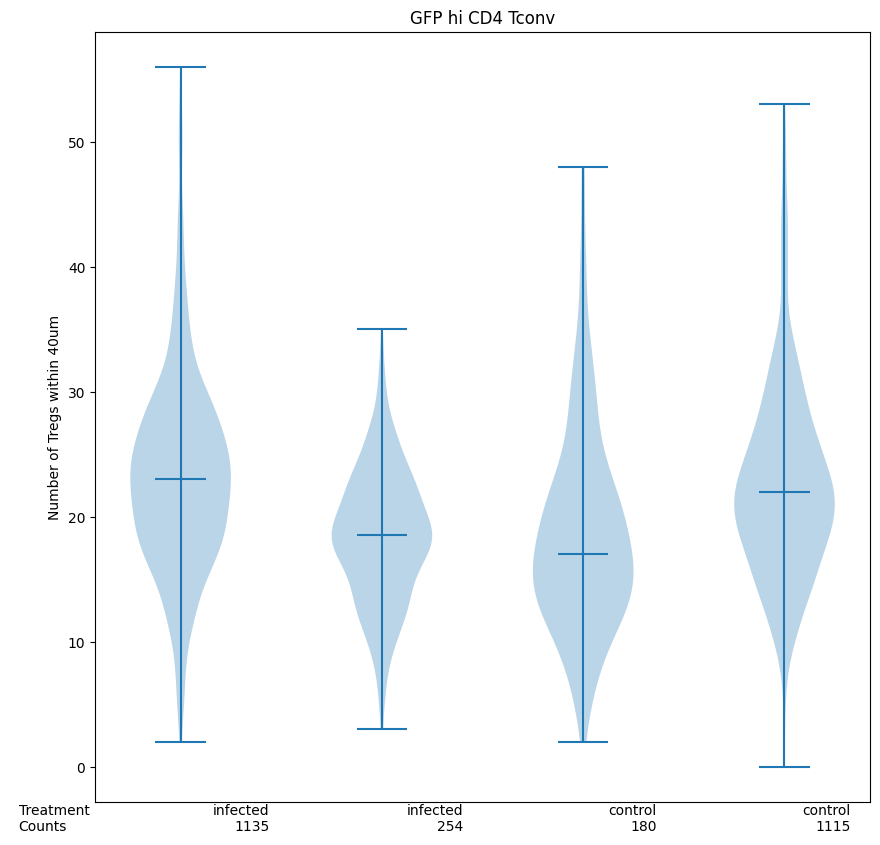

In [19]:
plot_data=[(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh]<d_max).sum(axis=1) for sample in samples]
plt.violinplot(plot_data,showmedians=True)
plt.ylabel(f'Number of Tregs within {d_max}um')
plt.table(cellText=[[condition(sample) for sample in samples],[len(arr) for arr in plot_data]],
                      rowLabels=['Treatment','Counts'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('GFP hi CD4 Tconv')

In [22]:
print([(cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh).sum() for sample in samples])

[1135, 254, 180, 1115]


# Spatial Analysis: Ki67

In [ ]:
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC'][cells[f'{sample}_Treg']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0) for sample in samples],showmedians=True)
plt.ylabel(f'Number of Ki67+ Tregs within {d_max}um')
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs')

In [ ]:
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0) for sample in samples]
plot_data_shuffle=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_Ki67'])>Ki67_hi_thresh,:]<d_max),axis=0) for sample in samples]
plt.violinplot(plot_data,showmedians=True)
# plt.violinplot(plot_data_shuffle,showmedians=True)
jitter=0.1
# for i, arr in enumerate(plot_data):
#     plt.scatter(np.full(len(arr),i+1)+np.random.normal(scale=jitter,size=len(arr)),arr,s=5,alpha=0.5,c='C0')
plt.ylabel(f'Number of Ki67+ CD4 Tconv within {d_max}um')
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs')

In [28]:
dense_thresh=5

In [ ]:
for sample in samples:
    plt.scatter(add_jitter(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0),jitter=0.1),
                add_jitter(np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC'][cells[f'{sample}_Treg']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0),jitter=0.1),alpha=0.5,s=10)
plt.xlabel(f'Number of Ki67 hi CD4 Tconv within {d_max} um')
plt.ylabel(f'Number of Ki67 hi Treg within {d_max} um')
plt.title('Migratory APCs')

In [ ]:
plt_data=[np.concatenate([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC'][cells[f'{sample}_Treg']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:][:,np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0)>=dense_thresh]<d_max),axis=0) for sample in samples]),
                np.concatenate([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC'][cells[f'{sample}_Treg']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:][:,np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0)<dense_thresh]<d_max),axis=0) for sample in samples])]
plt.violinplot(plt_data,showmedians=True,bw_method=0.5)
plt.scatter(add_jitter(np.concatenate([[i+1]*len(arr) for i,arr in enumerate(plt_data)]),jitter=0.1),np.concatenate(plt_data),s=5,alpha=0.2,c='orange')
plt.xticks([])
plt.ylabel(f'Number of Ki67 hi Treg within {d_max}um')
plt.table(cellText=[['Ki67 dense APCs','all APCs']],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')

In [ ]:
plt_data=[np.concatenate([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC'][:,np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0)>=dense_thresh]<d_max),axis=0) for sample in samples]),
                np.concatenate([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC'][:,np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0)<dense_thresh]<d_max),axis=0) for sample in samples])]
plt.violinplot(plt_data,showmedians=True)
plt.scatter(add_jitter(np.concatenate([[i+1]*len(arr) for i,arr in enumerate(plt_data)]),jitter=0.1),np.concatenate(plt_data),s=5,alpha=0.2,c='orange')
plt.xticks([])
plt.ylabel(f'Number of Treg within {d_max}um')
plt.table(cellText=[['Ki67 dense APCs','all APCs']],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')

In [ ]:
for sample in samples:
    plt.scatter(add_jitter(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0),jitter=0.1),
                add_jitter(np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0),jitter=0.1),alpha=0.5,s=10)
plt.xlabel(f'Number of Ki67 hi CD4 Tconv within {d_max} um')
plt.ylabel(f'Number of Treg within {d_max} um')
plt.title('Migratory APCs')

In [ ]:
for sample in samples:
    proximal_ki67_number=np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0)
    proximal_Treg_number=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)
    plot_data=[[] for _ in range(max(proximal_ki67_number+1))]
    for i in range(len(cells[f'{sample}_mAPC'])):
        plot_data[proximal_ki67_number[i]].append(proximal_Treg_number[i])
    plot_data=[arr  if arr else [float('nan'),float('nan')] for arr in plot_data]
    plt.violinplot(plot_data,showmedians=True,showextrema=False)
plt.xlabel(f'Number of Ki67 hi CD4 Tconv within {d_max} um')
plt.ylabel(f'Number of Treg within {d_max} um')
plt.title('Migratory APCs')

In [ ]:
fig,axs=plt.subplots(1,6,figsize=(25,5),sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axs[i].hist([np.sum(np.int8(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_Ki67'])>Ki67_hi_thresh,:]<d_max),axis=0)>=dense_thresh)) for _ in range(100)],label='shuffle')
    axs[i].plot([np.sum(np.int8(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0)>=dense_thresh))]*2,[0,40],label='observed')
    axs[i].set_title(condition(sample))
    axs[i].legend(loc='upper right')
fig.supxlabel(f'Number of APCs with more than {dense_thresh} Ki67+ CD4 Tconvs within {d_max} um')
fig.supylabel('Counts')

In [ ]:
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_Ki67'])>Ki67_hi_thresh,:]<d_max),axis=0) for sample in samples],showmedians=True)

plt.ylabel(f'Number of Ki67+ CD4 Tconv within {d_max}um')
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs null model',c='r')


In [ ]:
ki67_dense_apc_df=[cells[f'{sample}_mAPC'][np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0)>=dense_thresh] for sample in samples]
fig,axs=plt.subplots(1,6,figsize=(25,5))
fig.suptitle('Activation dense APCs')
for i, sample in enumerate(samples):
    treg_kde=scipy.stats.gaussian_kde(cells[f'{sample}_Treg'][['Position_X','Position_Y']].T,bw_method=0.1)
    x_arr=np.linspace(np.min(cells[f'{sample}_paracortex']['Position_X']),np.max(cells[f'{sample}_paracortex']['Position_X']),250)
    y_arr=np.linspace(np.min(cells[f'{sample}_paracortex']['Position_Y']),np.max(cells[f'{sample}_paracortex']['Position_Y']),250)
    axs[i].contourf(x_arr,y_arr,treg_kde(np.vstack([arr.ravel() for arr in np.meshgrid(x_arr,y_arr)])).T.reshape(len(x_arr),len(y_arr)),levels=50,cmap='Greens')
    axs[i].scatter(ki67_dense_apc_df[i]['Position_X'],ki67_dense_apc_df[i]['Position_Y'],alpha=0.7)
    # axs[i].scatter(cells[f'{sample}_mAPC']['Position_X'],cells[f'{sample}_mAPC']['Position_Y'],alpha=0.3)
    axs[i].scatter(cells[f'{sample}_paracortex']['Position_X'],cells[f'{sample}_paracortex']['Position_Y'],s=0.1,alpha=0.1)
    axs[i].set_aspect('equal')
    axs[i].invert_yaxis()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(condition(sample))

In [ ]:
ki67_dense_apc_df=[cells[f'{sample}_mAPC'][np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=0)>=dense_thresh] for sample in samples]
fig,axs=plt.subplots(1,4,figsize=(25,5))
fig.suptitle('All APCs')
for i, sample in enumerate(samples):
    treg_kde=scipy.stats.gaussian_kde(cells[f'{sample}_Treg'][['Position_X','Position_Y']].T,bw_method=0.1)
    x_arr=np.linspace(np.min(cells[f'{sample}_paracortex']['Position_X']),np.max(cells[f'{sample}_paracortex']['Position_X']),250)
    y_arr=np.linspace(np.min(cells[f'{sample}_paracortex']['Position_Y']),np.max(cells[f'{sample}_paracortex']['Position_Y']),250)
    axs[i].contourf(x_arr,y_arr,treg_kde(np.vstack([arr.ravel() for arr in np.meshgrid(x_arr,y_arr)])).T.reshape(len(x_arr),len(y_arr)),levels=50,cmap='Greens')
    axs[i].scatter(cells[f'{sample}_mAPC']['Position_X'],cells[f'{sample}_mAPC']['Position_Y'],alpha=0.3)
    axs[i].scatter(cells[f'{sample}_paracortex']['Position_X'],cells[f'{sample}_paracortex']['Position_Y'],s=0.1,alpha=0.1)
    axs[i].set_aspect('equal')
    axs[i].invert_yaxis()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(condition(sample))

In [ ]:
for sample in samples:
    if condition(sample)=='KLH':
        color='C0'
    else: #PBS
        color='orange'
    plt.scatter(np.log10(cells[f'{sample}_Treg']['Intensity_Mean_Ki67']+0.01),cells[f'{sample}_Treg']['distance_mAPC'],s=1,c=color)

plt.xlabel('log Mean Ki67')
plt.ylabel('distance from nearest mAPC')
plt.ylim(0,100)
plt.title('Tregs')

In [ ]:
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_low_thresh,:]<d_max),axis=1) for sample in samples]
plt.violinplot(plot_data,showmedians=True)
plt.ylabel(f'Number of Tregs within {d_max} um')
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Ki67+ Tconvs')

In [ ]:
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=1) for sample in samples],quantiles=[[0,0.25,0.5,0.75,1] for _ in range(4)])
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']<Ki67_low_thresh,:]<d_max),axis=1) for sample in samples],quantiles=[[0,0.25,0.5,0.75,1] for _ in range(4)])
plt.ylabel(f'Number of Tregs within {d_max} um')
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Ki67 hi Tconvs and Ki67 off Tconvs')

In [ ]:
d_max=25
# cells[f'{sample}_Treg'][np.any(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh]<d_max,axis=0)]
plt.violinplot([np.log10(cells[f'{sample}_Treg']['Intensity_Mean_Ki67']+1e-3).iloc[np.argwhere(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh]<d_max)[:,1]] for sample in samples])
plt.violinplot([np.log10(cells[f'{sample}_Treg']['Intensity_Mean_Ki67']+1e-3).iloc[np.argwhere(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']<Ki67_low_thresh]<d_max)[:,1]] for sample in samples])
plt.ylabel(f'log Ki67 mean on Tregs within {d_max} um')
plt.title('Ki67 hi CD4 Tconv and Ki67 off CD4 Tconv')

In [ ]:
d_max=40
plot_data=[np.concatenate([np.sum(np.int8(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']>Ki67_hi_thresh,:]<d_max),axis=1) for sample in samples]),np.concatenate([np.sum(np.int8(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_Ki67']<Ki67_low_thresh,:]<d_max),axis=1) for sample in samples])]
plt.violinplot(plot_data,showmedians=True)
plt.ylabel(f'Number of Tregs within {d_max} um')
plt.table(cellText=[['Ki67 hi','Ki67 off']],
                      rowLabels=['Treatment'],loc='bottom',edges='open')
plt.xticks([])
plt.title('Tconvs')

In [74]:
# plot_data=[]
# for sample in samples:
#     mask=np.array(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']>nur77_thresh)
#     idx=np.array([i for i,truth in enumerate(mask) if truth],dtype=np.int32)
#     plot_data.append(np.sum(np.int8(cell_pairs[f'{sample}_Th_mig'][idx,:]<d_max),axis=0))
# plt.violinplot(plot_data,showmedians=True)
# plt.ylabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
# plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
#                       rowLabels=['Treatment','','Opposing side'],
#                       loc='bottom',
#                       edges='open')
# plt.xticks([])
# plt.title('Migratory APCs')

# Spatial Analysis: GFP

In [ ]:
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0) for sample in injected_samples]
# plot_data_shuffle=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_GFP'])>gfp_hi_thresh,:]<d_max),axis=0) for sample in samples]
plt.violinplot(plot_data,showmedians=True)
# plt.violinplot(plot_data_shuffle,showmedians=True)
# for i, arr in enumerate(plot_data):
#     plt.scatter(np.full(len(arr),i+1)+np.random.normal(scale=jitter,size=len(arr)),arr,s=5,alpha=0.5,c='C0')
plt.ylabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
plt.table(cellText=[[condition(sample) for sample in injected_samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs')

In [76]:
dense_thresh=25

In [ ]:
fig,axs=plt.subplots(1,6,figsize=(25,5),sharex=True,sharey=True)
for i, sample in enumerate(injected_samples):
    axs[i].hist([np.sum(np.int8(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_GFP']).reset_index(drop=True)>gfp_hi_thresh,:]<d_max),axis=0)>=dense_thresh)) for _ in range(100)],label='shuffle')
    axs[i].plot([np.sum(np.int8(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0)>=dense_thresh))]*2,[0,40],label='observed')
    axs[i].set_title(condition(sample))
    axs[i].legend(loc='upper right')
fig.supxlabel(f'Number of APCs with more than {dense_thresh} GFP+ CD4 Tconvs within {d_max} um')
fig.supylabel('Counts')

In [ ]:
d_max=350
dense_thresh=200
fig,axs=plt.subplots(1,6,figsize=(25,5),sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axs[i].hist([np.sum(np.int8(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_GFP']).reset_index(drop=True)>gfp_hi_thresh,:]<d_max),axis=0)>=dense_thresh)) for _ in range(100)],label='shuffle')
    axs[i].plot([np.sum(np.int8(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0)>=dense_thresh))]*2,[0,40],label='observed')
    axs[i].set_title(condition(sample))
    axs[i].legend(loc='upper right')
fig.supxlabel(f'Number of APCs with more than {dense_thresh} GFP+ CD4 Tconvs within {d_max} um')
fig.supylabel('Counts')

In [ ]:
d_max=40
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=1) for sample in samples],quantiles=[[0,0.25,0.5,0.75,1] for _ in range(6)],side='low')
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Th_Treg'][cells[f'{sample}_Th']['Intensity_Mean_GFP']<gfp_lo_thresh,:]<d_max),axis=1) for sample in samples],quantiles=[[0,0.25,0.5,0.75,1] for _ in range(6)],side='high')
plt.ylabel(f'Number of Tregs within {d_max} um')
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('GFP hi Tconvs and GFP off Tconvs')

In [ ]:
proximal_gfp_number=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0) for sample in injected_samples]
proximal_Treg_number=[np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0) for sample in injected_samples]
max_proximal_gfp_number=np.max(np.concatenate(proximal_gfp_number))
for cond in ['KLH','OVA']:
    plot_data=[[] for _ in range(max_proximal_gfp_number+1)]
    for i,sample in enumerate(samples):
        if condition(sample)==cond:
            for j in range(len(cells[f'{sample}_mAPC'])):
                plot_data[proximal_gfp_number[i][j]].append(proximal_Treg_number[i][j])
    plot_data=[arr if arr else [float('nan'),float('nan')] for arr in plot_data]
    if cond=='KLH':
        plt.violinplot(plot_data,showmedians=True,showextrema=False,side='low')
    elif cond=='OVA':
        plt.violinplot(plot_data,showmedians=True,showextrema=False,side='high')
plt.xlabel(f'Number of GFP hi CD4 Tconv within {d_max} um')
plt.ylabel(f'Number of Treg within {d_max} um')
plt.title('Migratory APCs: KLH vs OVA')

# for sample in samples:
#     proximal_gfp_number=np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0)
#     proximal_Treg_number=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)
#     plot_data=[[] for _ in range(max(proximal_gfp_number+1))]
#     for i in range(len(cells[f'{sample}_mAPC'])):
#         plot_data[proximal_gfp_number[i]].append(proximal_Treg_number[i])
#     plot_data=[arr if arr else [float('nan'),float('nan')] for arr in plot_data]
#     if condition(sample)=='KLH':
#         plt.violinplot(plot_data,showmedians=True,showextrema=False,side='low')
#     elif condition(sample)=='OVA':
#         plt.violinplot(plot_data,showmedians=True,showextrema=False,side='high')
# plt.xlabel(f'Number of Ki67 hi CD4 Tconv within {d_max} um')
# plt.ylabel(f'Number of Treg within {d_max} um')
# plt.title('Migratory APCs')

In [ ]:
dense_thresh=15
d_max=40
proximal_gfp_number_mask=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0)>=dense_thresh for sample in samples]
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)[proximal_gfp_number_mask[i]] for i,sample in enumerate(samples)],side='low',showmedians=True)
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)[np.logical_not(proximal_gfp_number_mask[i])] for i,sample in enumerate(samples)],side='high',showmedians=True)
plt.xticks([])
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.ylabel('Number of Treg within 40 um')
plt.title('GFP dense APCs vs GFP sparse APCs')
#     proximal_Treg_number=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)
#     plot_data=[[] for _ in range(max(proximal_gfp_number+1))]
#     for i in range(len(cells[f'{sample}_mAPC'])):
#         plot_data[proximal_gfp_number[i]].append(proximal_Treg_number[i])
#     plot_data=[arr if arr else [float('nan'),float('nan')] for arr in plot_data]
#     if condition(sample)=='KLH':
#         plt.violinplot(plot_data,showmedians=True,showextrema=False,side='low')
#     elif condition(sample)=='OVA':
#         plt.violinplot(plot_data,showmedians=True,showextrema=False,side='high')
# plt.xlabel(f'Number of Ki67 hi CD4 Tconv within {d_max} um')
# plt.ylabel(f'Number of Treg within {d_max} um')
# plt.title('Migratory APCs')

In [ ]:
np.logical_and(cell_pairs[f'{sample}_Th_mAPC']<d_max,cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh)

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    th_mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh
    pairs_mask=(cell_pairs[f'{sample}_Th_mAPC']<d_max)[th_mask]
    proximal_gfp_series=pairs_mask.sum(axis=0)
    gfp_dist_series=[cells[f'{sample}_Th']['Intensity_Mean_GFP'][th_mask][pairs_mask[:,i]] for i in range(pairs_mask.shape[1])]
    percentile_series=np.stack([np.percentile(series,[50,90]) if not series.empty else [float('nan')]*2 for series in gfp_dist_series])
    bin_wise_boxplot(x=proximal_gfp_series,y=percentile_series[:,0],ax=axs[axi])
    bin_wise_boxplot(x=proximal_gfp_series,y=percentile_series[:,1],ax=axs[axi])
    axs[axi].set_title(condition(sample))

fig.supxlabel('number of proximal GFP hi CD4 Tconv')
fig.supylabel('Nur77 GFP MFI of surrounding GFP hi CD4 Tconv')
fig.suptitle('migratory APC; distribution of median and 90th percentile')

In [ ]:
# gfp_dist_series
# np.stack([np.percentile(series,[0.5,0.9]) for series in gfp_dist_series])
for series in gfp_dist_series:
    try:
        np.percentile(series,[0.5,0.9])
    except:
        print(series)

In [ ]:
np.percentile

# Spatial Analysis: pSTAT

In [ ]:
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max),axis=0) for sample in injected_samples]
# plot_data_shuffle=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_GFP'])>gfp_hi_thresh,:]<d_max),axis=0) for sample in samples]
plt.violinplot(plot_data,showmedians=True)
# plt.violinplot(plot_data_shuffle,showmedians=True)
# for i, arr in enumerate(plot_data):
#     plt.scatter(np.full(len(arr),i+1)+np.random.normal(scale=jitter,size=len(arr)),arr,s=5,alpha=0.5,c='C0')
plt.ylabel(f'Number of pSAT5+ CD4 Tconv within {d_max}um')
plt.table(cellText=[[condition(sample) for sample in injected_samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs')

In [33]:
dense_thresh_pstat=20

In [ ]:
fig,axs=plt.subplots(1,6,figsize=(25,5),sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axs[i].hist([np.sum(np.int8(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']).reset_index(drop=True)>pstat_thresh,:]<d_max),axis=0)>=dense_thresh_pstat)) for _ in range(100)],label='shuffle')
    axs[i].plot([np.sum(np.int8(np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max),axis=0)>=dense_thresh_pstat))]*2,[0,40],label='observed')
    axs[i].set_title(condition(sample))
    axs[i].legend(loc='upper right')
fig.supxlabel(f'Number of APCs with more than {dense_thresh_pstat} pSTAT+ CD4 Tconvs within {d_max} um')
fig.supylabel('Counts')

In [ ]:
proximal_pstat_number=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max),axis=0) for sample in injected_samples]
proximal_Treg_number=[np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0) for sample in injected_samples]
max_proximal_pstat_number=np.max(np.concatenate(proximal_pstat_number))
for cond in ['KLH','OVA']:
    plot_data=[[] for _ in range(max_proximal_pstat_number+1)]
    for i,sample in enumerate(samples):
        if condition(sample)==cond:
            for j in range(len(cells[f'{sample}_mAPC'])):
                plot_data[proximal_pstat_number[i][j]].append(proximal_Treg_number[i][j])
    plot_data=[arr if arr else [float('nan'),float('nan')] for arr in plot_data]
    if cond=='KLH':
        plt.violinplot(plot_data,showmedians=True,showextrema=False,side='low')
    elif cond=='OVA':
        plt.violinplot(plot_data,showmedians=True,showextrema=False,side='high')
plt.xlabel(f'Number of pSTAT5+ CD4 Tconv within {d_max} um')
plt.ylabel(f'Number of Treg within {d_max} um')
plt.title('Migratory APCs: KLH vs OVA')

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    pstat_series=np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max),axis=0)
    treg_series=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)
    bin_wise_boxplot(pstat_series,treg_series,bins=10,ax=axs[axi])
    # axs[axi].scatter(add_jitter(proximal_cells_series,0.1),signal_series,s=1,alpha=0.3)
    axs[axi].set_title(condition(sample)) 
fig.supxlabel('number of proximal pSTAT5+ CD4 Tconv')
fig.supylabel('number of proximal Treg')
fig.suptitle('migratory APCs')

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    pstat_series=np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max),axis=0)
    treg_series=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC'][cells[f'{sample}_Treg']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max),axis=0)
    bin_wise_boxplot(pstat_series,treg_series,bins=10,ax=axs[axi])
    # axs[axi].scatter(add_jitter(proximal_cells_series,0.1),signal_series,s=1,alpha=0.3)
    axs[axi].set_title(condition(sample)) 
fig.supxlabel('number of proximal pSTAT5+ CD4 Tconv')
fig.supylabel('number of proximal pSTAT5+ Treg')
fig.suptitle('migratory APCs')

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    pstat_series=np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max),axis=0)
    treg_series=(cell_pairs[f'{sample}_Treg_mAPC'][cells[f'{sample}_Treg']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max).sum(axis=0)/(cell_pairs[f'{sample}_Treg_mAPC']<d_max).sum(axis=0)
    bin_wise_boxplot(pstat_series,treg_series,bins=10,ax=axs[axi])
    # axs[axi].scatter(add_jitter(proximal_cells_series,0.1),signal_series,s=1,alpha=0.3)
    axs[axi].set_title(condition(sample)) 
fig.supxlabel('number of proximal pSTAT5+ CD4 Tconv')
fig.supylabel('fraction pSTAT5+ of proximal Treg')
fig.suptitle('migratory APCs')

In [ ]:
(cell_pairs[f'_Treg_mAPC']<d_max).sum(axis=0)

In [ ]:
dense_thresh=15
d_max=40
proximal_gfp_number_mask=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0)>=dense_thresh for sample in samples]
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)[proximal_gfp_number_mask[i]] for i,sample in enumerate(samples)],side='low',showmedians=True)
plt.violinplot([np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)[np.logical_not(proximal_gfp_number_mask[i])] for i,sample in enumerate(samples)],side='high',showmedians=True)
plt.xticks([])
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.ylabel('Number of Treg within 40 um')
plt.title('GFP dense APCs vs GFP sparse APCs')
#     proximal_Treg_number=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mAPC']<d_max),axis=0)
#     plot_data=[[] for _ in range(max(proximal_gfp_number+1))]
#     for i in range(len(cells[f'{sample}_mAPC'])):
#         plot_data[proximal_gfp_number[i]].append(proximal_Treg_number[i])
#     plot_data=[arr if arr else [float('nan'),float('nan')] for arr in plot_data]
#     if condition(sample)=='KLH':
#         plt.violinplot(plot_data,showmedians=True,showextrema=False,side='low')
#     elif condition(sample)=='OVA':
#         plt.violinplot(plot_data,showmedians=True,showextrema=False,side='high')
# plt.xlabel(f'Number of Ki67 hi CD4 Tconv within {d_max} um')
# plt.ylabel(f'Number of Treg within {d_max} um')
# plt.title('Migratory APCs')

In [ ]:
for i,sample in enumerate(samples):
    plt.scatter(add_jitter(proximal_gfp_number[i],0.2),add_jitter(proximal_pstat_number[i],0.2),label=condition(sample),s=5,alpha=0.5)

plt.title('migratory APCs')
plt.xlabel('number of proximal GFP hi CD4 Tconv')
plt.ylabel('number of proximal pSTAT5+ CD4 Tconv')
plt.legend()

In [ ]:
fig,axs=plt.subplots(2,3,figsize=(30,20))
for i,sample in enumerate(samples):
    ax=axs[i//3,i%3]
    th_mask=np.logical_and(cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']>pstat_thresh,cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh)
    pstat_dense_apc_mask=(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']>pstat_thresh,:]<d_max).sum(axis=0)>=dense_thresh_pstat
    s1=ax.scatter(cells[f'{sample}_mAPC']['Position_X'],cells[f'{sample}_mAPC']['Position_Y'])
    s2=ax.scatter(cells[f'{sample}_Th'][th_mask]['Position_X'],cells[f'{sample}_Th'][th_mask]['Position_Y'],s=3,alpha=0.3)
    s3=ax.scatter(cells[f'{sample}_mAPC'][pstat_dense_apc_mask]['Position_X'],cells[f'{sample}_mAPC'][pstat_dense_apc_mask]['Position_Y'])
    ax.set_title(condition(sample))
    ax.set_aspect('equal')
fig.legend([s1,s2,s3],labels=['migratory APC','GFP hi pSTAT+ CD4 Tconv','pSTAT dense migratory APC'])

# Tconv-centred analysis

In [ ]:
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Th_Th'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0) for sample in samples]
# plot_data_shuffle=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_GFP'])>gfp_hi_thresh,:]<d_max),axis=0) for sample in samples]
plt.violinplot(plot_data,showmedians=True)
# plt.violinplot(plot_data_shuffle,showmedians=True)
# for i, arr in enumerate(plot_data):
#     plt.scatter(np.full(len(arr),i+1)+np.random.normal(scale=jitter,size=len(arr)),arr,s=5,alpha=0.5,c='C0')
plt.ylabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('CD4 Tconv')

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    proximal_cells_series=np.sum(np.int8(cell_pairs[f'{sample}_Th_Th'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh]<d_max),axis=0)
    signal_series=np.log10(cells[f'{sample}_Th']['Intensity_Mean_GFP']+1e-3)
    bin_wise_boxplot(proximal_cells_series,signal_series,bins=10,ax=axs[axi],vmin=0,vmax=0.1)
    # axs[axi].scatter(add_jitter(proximal_cells_series,0.1),signal_series,s=1,alpha=0.3)
    axs[axi].set_title(condition(sample)) 
fig.supxlabel('number of proximal GFP hi CD4 Tconv')
fig.supylabel('log Nur77 GFP MFI')
fig.suptitle('all CD4 Tconv')
    # axs[i//3,i]
    # l=skmisc.loess.loess(proximal_cells_series,signal_series,span=0.5,surface='direct')
    # l.fit()
    # plot_x=np.arange(0,25)
    # pred=l.predict(plot_x,stderror=False)
    # plt.plot(plot_x,pred.values,label=0.5)
    # conf = pred.confidence()
    # ll = conf.lower
    # ul = conf.upper
    # plt.fill_between(plot_x,ll,ul,alpha=.33)

# plt.title('CD4 Tconv')
# plt.xlabel('Number of proximal Nur77 hi CD4 Tconv')
# plt.ylabel('log Nur77 GFP MFI')


In [ ]:
for i, sample in enumerate(samples):
    plt.scatter(add_jitter(np.sum(np.int8(cell_pairs[f'{sample}_Th_Th'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh]<d_max),axis=0),0.1),np.log10(cells[f'{sample}_Th']['Intensity_Mean_GFP']+1e-3),s=1,alpha=0.3,label=condition(sample))

plt.title('CD4 Tconv')
plt.xlabel('Number of proximal Nur77 hi CD4 Tconv')
plt.ylabel('log Nur77 GFP MFI')

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    proximal_cells_series=np.sum(np.int8(cell_pairs[f'{sample}_Th_Th'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh]<d_max),axis=0)
    signal_series=np.log10(cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']+1e-3)
    bin_wise_boxplot(proximal_cells_series,signal_series,bins=10,ax=axs[axi])
    # axs[axi].scatter(add_jitter(proximal_cells_series,0.1),signal_series,s=1,alpha=0.3)
    axs[axi].set_title(condition(sample)) 
fig.supxlabel('number of proximal GFP hi CD4 Tconv')
fig.supylabel('log pSTAT5 MFI')
fig.suptitle('all CD4 Tconv')

In [ ]:
sample='1L2'
mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh
cell_pairs[f'{sample}_Th_Th'][mask][:,mask]<d_

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh
    proximal_cells_series=np.sum(np.int8(cell_pairs[f'{sample}_Th_Th'][mask][:,mask]<d_max),axis=0)
    signal_series=np.log10(cells[f'{sample}_Th'][mask]['Intensity_Mean_GFP']+1e-3)
    # print(proximal_cells_series,signal_series)
    bin_wise_boxplot(proximal_cells_series,signal_series,bins=10,ax=axs[axi],vmin=0,vmax=0.1)
    # axs[axi].scatter(add_jitter(proximal_cells_series,0.1),signal_series,s=1,alpha=0.3)
    axs[axi].set_title(condition(sample)) 
fig.supxlabel('number of proximal GFP hi CD4 Tconv')
fig.supylabel('log Nur77 GFP MFI')
fig.suptitle('GFP hi CD4 Tconv')

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh
    proximal_cells_series=np.sum(np.int8(cell_pairs[f'{sample}_Th_Th'][mask][:,mask]<d_max),axis=0)
    signal_series=np.log10(cells[f'{sample}_Th'][mask]['Intensity_Mean_pSTAT5']+1e-3)
    # print(proximal_cells_series,signal_series)
    bin_wise_boxplot(proximal_cells_series,signal_series,bins=10,ax=axs[axi],vmin=0,vmax=0.1)
    # axs[axi].scatter(add_jitter(proximal_cells_series,0.1),signal_series,s=1,alpha=0.3)
    axs[axi].set_title(condition(sample)) 
fig.supxlabel('number of proximal GFP hi CD4 Tconv')
fig.supylabel('log pSTAT5 MFI')
fig.suptitle('GFP hi CD4 Tconv')

In [ ]:
fig,axs=plt.subplots(2,3,sharex=True,sharey=True)
for i, sample in enumerate(samples):
    axi=(i//3,i%3)
    proximal_cells_series=np.sum(np.int8(cell_pairs[f'{sample}_Th_Th'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh][:,cells[f'{sample}_Th']['distance_mAPC']<d_max]<d_max),axis=0)
    signal_series=np.log10(cells[f'{sample}_Th']['Intensity_Mean_pSTAT5']+1e-3)
    bin_wise_boxplot(proximal_cells_series,signal_series,bins=10,ax=axs[axi])
    # axs[axi].scatter(add_jitter(proximal_cells_series,0.1),signal_series,s=1,alpha=0.3)
    axs[axi].set_title(condition(sample)) 
fig.supxlabel('number of proximal GFP hi CD4 Tconv')
fig.supylabel('log pSTAT5 MFI')
fig.suptitle(f'CD4 Tconv within {d_max}um of an APC')

# $p$ hacking

In [ ]:
n_range=np.arange(1,40)
d_range=np.arange(5,75,5)
delta_container=np.zeros((len(d_range),len(n_range)))
for i,d in enumerate(d_range):
    proximal_th_gfp_counts=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh]<d),axis=0) for sample in samples]
    for j,n in enumerate(n_range):
        dense_prop=[np.sum(np.int8(arr>=n))/len(arr) for arr in proximal_th_gfp_counts]
        delta_container[i,j]=np.mean([dense_prop[k] for k,sample in enumerate(samples) if condition(sample)=='KLH'])-np.mean([dense_prop[k] for k,sample in enumerate(samples) if condition(sample)=='OVA'])

plt.imshow(delta_container,origin='lower',extent=(n_range[0],n_range[-1]+1,d_range[0],d_range[-1]+5),aspect='auto')
plt.colorbar(label='difference in proportion of GFP dense APCs in KLH over OVA')
plt.xlabel('number cutoff for GFP dense APC')
plt.ylabel('distance cutoff for proximal activated T cell')

In [ ]:
d_max=70
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh,:]<d_max),axis=0) for sample in samples]
# plot_data_shuffle=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][sklearn.utils.shuffle(cells[f'{sample}_Th']['Intensity_Mean_GFP'])>gfp_hi_thresh,:]<d_max),axis=0) for sample in samples]
plt.violinplot(plot_data,showmedians=True)
# plt.violinplot(plot_data_shuffle,showmedians=True)
# for i, arr in enumerate(plot_data):
#     plt.scatter(np.full(len(arr),i+1)+np.random.normal(scale=jitter,size=len(arr)),arr,s=5,alpha=0.5,c='C0')
plt.ylabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
plt.table(cellText=[[condition(sample) for sample in samples]],
                      rowLabels=['Treatment'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs')

In [ ]:
n_range=np.arange(1,40)
d_range=np.arange(5,55,5)
for sample in samples:
    arrs=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh]<d),axis=0) for d in d_range]
    plt.plot(d_range,[np.median(arr) for arr in arrs],label=condition(sample))

plt.xlabel('distance cutoff for proximal activated T cell')
plt.ylabel('median number of activated T cells on APC')
plt.legend()
plt.title('Polr2a surfaces')

In [ ]:
np.logspace(-1.,1.,30)

In [ ]:
thresh_range=np.arange(-1.,1.,0.05)
d_range=np.arange(5,75,5)
delta_container=np.zeros((len(thresh_range),len(d_range)))
for i, thresh in enumerate(thresh_range):
    activated_th_masks=[cells[f'{sample}_Th']['Intensity_Mean_GFP']>10**thresh for sample in samples]
    for j,d in enumerate(d_range):
        proximal_th_gfp_counts=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][activated_th_masks[k]]<d),axis=0) for k,sample in enumerate(samples)]
        delta_container[i,j]=np.median(np.concatenate([proximal_th_gfp_counts[k] for k,sample in enumerate(samples) if condition(sample)=='KLH']))-np.median(np.concatenate([proximal_th_gfp_counts[k] for k,sample in enumerate(samples) if condition(sample)=='OVA']))

plt.imshow(delta_container,origin='lower',extent=(d_range[0],2*d_range[-1]-d_range[-2],thresh_range[0],2*thresh_range[-1]-thresh_range[-2]),aspect='auto')
plt.colorbar(label='difference in median number of activated CD4 Tconv on APCs in KLH over OVA')
plt.ylabel('log GFP intensity cutoff for activated T cell')
plt.xlabel('distance cutoff for proximal activated T cell')
plt.title('Polr2a surfaces')

In [ ]:
thresh_range=np.arange(-1.,1.,0.05)
n_range=np.arange(1,40)
d=40
delta_container=np.zeros((len(thresh_range),len(n_range)))
for i, thresh in enumerate(thresh_range):
    activated_th_masks=[cells[f'{sample}_Th']['Intensity_Mean_GFP']>10**thresh for sample in samples]
    for j,n in enumerate(n_range):
        proximal_th_gfp_counts=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mAPC'][activated_th_masks[k]]<d),axis=0) for k,sample in enumerate(samples)]
        dense_prop=[np.sum(np.int8(arr>=n))/len(arr) for arr in proximal_th_gfp_counts]
        delta_container[i,j]=np.mean([dense_prop[k] for k,sample in enumerate(samples) if condition(sample)=='KLH'])-np.mean([dense_prop[k] for k,sample in enumerate(samples) if condition(sample)=='OVA'])

plt.imshow(delta_container,origin='lower',extent=(n_range[0],n_range[-1]*2-n_range[-2],thresh_range[0],2*thresh_range[-1]-thresh_range[-2]),aspect='auto')
plt.colorbar(label='difference in proportion of GFP dense APCs in KLH over OVA')
plt.xlabel('number cutoff for GFP dense APC')
plt.ylabel('log GFP mean intenstiy cutoff for activated T cell')
plt.title('Polr2a surfaces')

In [ ]:
thresh_range=np.arange(-1.,1.,0.05)
n_range=np.arange(1,40)
d=40
p_container=np.zeros((len(thresh_range),len(n_range)))
sample='1L2'

for i, thresh in enumerate(thresh_range):
    activated_th_mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>10**thresh
    shuffled_activated_th_masks=[sklearn.utils.shuffle(activated_th_mask) for _ in range(100)]
    proximal_th_gfp_counts=np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][activated_th_mask]<d,axis=0)
    proximal_th_gfp_counts_shuffle=[np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][mask]<d,axis=0) for mask in shuffled_activated_th_masks]
    for j,n in enumerate(n_range):
        dense_prop=np.count_nonzero(proximal_th_gfp_counts>=n)/len(proximal_th_gfp_counts)
        dense_prop_shuffle=np.array([np.sum(np.int8(arr>=n))/len(arr) for arr in proximal_th_gfp_counts_shuffle])
        p_value=np.count_nonzero(dense_prop_shuffle>=dense_prop)/100
        if p_value==1.0 and (dense_prop==0.0 or dense_prop==1.0):
            p_container[i,j]=np.NAN
        else:
            p_container[i,j]=p_value

plt.imshow(p_container,origin='lower',extent=(n_range[0],n_range[-1]*2-n_range[-2],thresh_range[0],2*thresh_range[-1]-thresh_range[-2]),aspect='auto')
plt.colorbar(label=r'$p$ of proportion of GFP dense APC over shuffled CD4 Tconv')
plt.xlabel('number cutoff for GFP dense APC')
plt.ylabel('log GFP mean intenstiy cutoff for activated T cell')
plt.title('KLH (one smaple)')

In [ ]:
n_range=np.arange(1,1100,20)
d_range=np.arange(5,1200,20)
p_container=np.zeros((len(d_range),len(n_range)))

fig,axs=plt.subplots(1,2,figsize=(12,5))
for k,sample in enumerate(['1L2','2L2']):
    activated_th_mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh
    shuffled_activated_th_masks=[sklearn.utils.shuffle(activated_th_mask) for _ in range(100)]
    for i, d in enumerate(d_range):
        proximal_th_gfp_counts=np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][activated_th_mask]<d,axis=0)
        proximal_th_gfp_counts_shuffle=[np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][mask]<d,axis=0) for mask in shuffled_activated_th_masks]
        for j,n in enumerate(n_range):
            dense_prop=np.count_nonzero(proximal_th_gfp_counts>=n)/len(proximal_th_gfp_counts)
            dense_prop_shuffle=np.array([np.sum(np.int8(arr>=n))/len(arr) for arr in proximal_th_gfp_counts_shuffle])
            p_value=np.count_nonzero(dense_prop_shuffle>=dense_prop)/100
            if p_value==1.0 and (dense_prop==0.0 or dense_prop==1.0):
                p_container[i,j]=np.NAN
            else:
                p_container[i,j]=p_value

    im=axs[k].imshow(p_container,origin='lower',extent=(n_range[0],n_range[-1]*2-n_range[-2],d_range[0],2*d_range[-1]-d_range[-2]),aspect='auto')
    axs[k].set_title(condition(sample))

fig.supxlabel('number cutoff for GFP dense APC')
fig.supylabel('distance cutoff for proximal activated T cell')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax,label=r'$p$ of proportion of GFP dense APC over shuffled CD4 Tconv')

In [ ]:
n_range=np.arange(1,50,1)
d_range=np.arange(5,70,5)
p_container=np.zeros((len(d_range),len(n_range)))

fig,axs=plt.subplots(1,2,figsize=(12,5))
for k,sample in enumerate(['1L2','1R2']):
    activated_th_mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh
    shuffled_activated_th_masks=[sklearn.utils.shuffle(activated_th_mask) for _ in range(100)]
    for i, d in enumerate(d_range):
        proximal_th_gfp_counts=np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][activated_th_mask]<d,axis=0)
        proximal_th_gfp_counts_shuffle=[np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][mask]<d,axis=0) for mask in shuffled_activated_th_masks]
        for j,n in enumerate(n_range):
            dense_prop=np.count_nonzero(proximal_th_gfp_counts>=n)/len(proximal_th_gfp_counts)
            dense_prop_shuffle=np.array([np.sum(np.int8(arr>=n))/len(arr) for arr in proximal_th_gfp_counts_shuffle])
            p_value=np.count_nonzero(dense_prop_shuffle>=dense_prop)/100
            if p_value==1.0 and (dense_prop==0.0 or dense_prop==1.0):
                p_container[i,j]=np.NAN
            else:
                p_container[i,j]=p_value

    im=axs[k].imshow(p_container,origin='lower',extent=(n_range[0],n_range[-1]*2-n_range[-2],d_range[0],2*d_range[-1]-d_range[-2]),aspect='auto',vmin=0,vmax=1)
    axs[k].set_title(condition(sample))

fig.supxlabel('number cutoff for GFP dense APC')
fig.supylabel('distance cutoff for proximal activated T cell')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax,label=r'$p$ of proportion of GFP dense APC over shuffled CD4 Tconv')

In [ ]:
sample='1L2'
activated_th_mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh
shuffle_mask=sklearn.utils.shuffle(activated_th_mask).reset_index(drop=True)
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(30,10))
for ax in axs:
    # ax.scatter(cells[f'{sample}_Th']['Position_X'],cells[f'{sample}_Th']['Position_Y'],alpha=0.3,s=2)
    ax.scatter(cells[f'{sample}_mAPC']['Position_X'],cells[f'{sample}_mAPC']['Position_Y'],label='mAPC')
    ax.set_aspect('equal')

dense_mAPC_mask=np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][activated_th_mask]<100,axis=0)>=70
shuffle_mAPC_mask=np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][shuffle_mask]<100,axis=0)>=70
# axs[0].scatter(cells[f'{sample}_mAPC'][dense_mAPC_mask]['Position_X'],cells[f'{sample}_mAPC'][dense_mAPC_mask]['Position_Y'])
# axs[1].scatter(cells[f'{sample}_mAPC'][shuffle_mAPC_mask]['Position_X'],cells[f'{sample}_mAPC'][shuffle_mAPC_mask]['Position_Y'])


axs[0].scatter(cells[f'{sample}_Th'][activated_th_mask]['Position_X'],cells[f'{sample}_Th'][activated_th_mask]['Position_Y'],s=5,alpha=0.5,label='GFP hi CD4 Tconv')
axs[1].scatter(cells[f'{sample}_Th'][shuffle_mask]['Position_X'],cells[f'{sample}_Th'][shuffle_mask]['Position_Y'],s=5,alpha=0.5,label='shuffled GFP hi CD4 Tconv')
axs[0].legend()
axs[1].legend()

In [ ]:
fig,axs=plt.subplots(1,4,figsize=(15,5))
d_max=40
for i,sample in enumerate(samples):
    th_mask=cells[f'{sample}_Th']['Intensity_Mean_GFP']>gfp_hi_thresh
    # apc_mask=np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][th_mask,:]<d_max,axis=0)<5
    apc_mask=np.count_nonzero(cell_pairs[f'{sample}_Th_mAPC'][th_mask,:]<d_max,axis=0)>-1
    axs[i].scatter(cells[f'{sample}_mAPC'][apc_mask]['Position_X'],cells[f'{sample}_mAPC'][apc_mask]['Position_Y'])
    axs[i].scatter(cells[f'{sample}_Th'][th_mask]['Position_X'],cells[f'{sample}_Th'][th_mask]['Position_Y'],s=3,alpha=0.3)
    axs[i].set_title(condition(sample))
    axs[i].set_aspect('equal')


In [ ]:
cells[f'{sample}_mAPC'][True]